# Hu Moments (Image Descriptor)
- Image moments are used to characterize the shape of an object in an image. 
- These moments capture basic information such as **area** of an object, the **centroid**, the **orientation** and other desirable properties
- Hu proposed 7 moments that can be used to characterize shape of an object. These moments are invariant to changes in rotation, translation, scale, and reflection.
- Moment based calculations are sensitive to initial calc of centroid since all further calc are based around the initial centroid

## What are Hu Moments used to describe
- Segmented binary shape is preferred to the boundary of the shape since it is less susceptible to noise.
- The descriptor returns a feature vector of seven values. 

## How they work
- Common moments are mean, variance, skew, and kurtosis.
- The regular moment of a shape in binary image is defined by. <br>
$$M_{ij} = \sum_{x}\sum_{y}x^i y^j I(x,y)$$
- Centroid is simply center of the shape. 
$$ \bar{x} = M_{10}/M_{00} $$
$$ \bar{y} = M_{01}/M_{00} $$
where 
$$ M_{10} = \sum_{x}\sum_{y}x I(x,y) $$
- Once we have centroid, we compute relative moments which are based on the centroid.
$$ \mu_{pq} = \sum_{x}\sum_{y}(x-\bar{x})^p (y-\bar{y})^q I(x,y)$$
- The seven separate moments are based around the above equation.

## Where is it implemented.
- *cv2.moments* gives $M_{10}$, $M_{00}$ and $M_{01}$, which is then supplied to *cv2.HuMoments* which gives out a 7-d feature vector.

### Pros:

- Very fast to compute.
- Low dimensional.
- Good at describing simple shapes.
- No parameters to tune.
- Invariant to changes in rotation, reflection, and scale.
- Translation invariance is obtained by using a tight cropping of the object to be described.

### Cons:

- Requires a very precise segmentation of the object to be described, which is often hard in the real world.
- Normally only used for simple 2D shapes — as shapes become more complex, Hu Moments are not often used.
- Hu Moment calculations are based on the initial centroid computation — if the initial centroid cannot be repeated for similar shapes, then Hu Moments will not obtain good matching accuracy.

## Example below
- We'll compute HuMoments for silhoutess of 3 aircrafts.

In [1]:
import sys
sys.path.append("../")

In [50]:
import cv2
import imutils
from cv_imshow import display_image, create_subplot
import numpy as np
import uuid
from sklearn.metrics.pairwise import pairwise_distances 
import glob

In [7]:
args = {
    "image":"../images/planes.png",
    "output":"../images/output/",
    "num_shapes":500
}

- Below, we calc hu moment for entire image which is wrong, since we have three separate objects in the image. 
- When we take entire image, the centroid becomes center of all shapes, which is wrong.

ORIGINAL MOMENTS: [ 8.89880773e-03  7.57204412e-05  2.38651674e-08  1.85900330e-08
  3.91558010e-16  1.61708196e-10 -2.12085766e-18]


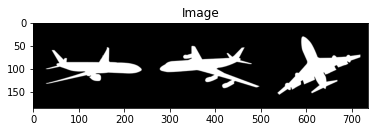

In [4]:
image = cv2.imread(args["image"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#compute hu moments feature vector for entire image
moments = cv2.HuMoments(cv2.moments(image)).flatten()
print("ORIGINAL MOMENTS: {}".format(moments))
display_image("Image", image)

- To correctly compute Hu Moments, we find contours and extract the ROI pertaining to objects and compute Hu Moments for each object

Moments for plane #1: [2.00162991e-03 3.01754249e-06 3.08984971e-11 4.14364409e-11
 4.97600769e-22 5.93897843e-14 1.39666817e-21]


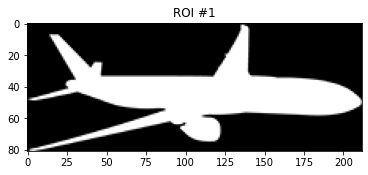

Moments for plane #2: [ 1.80851599e-03  1.92184829e-06  5.41577862e-10  4.41334901e-11
  5.46923123e-21 -2.19817014e-14 -4.07951523e-21]


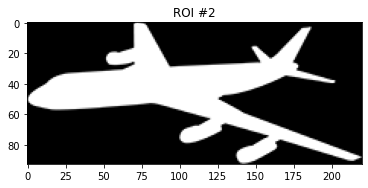

Moments for plane #3: [1.18498670e-03 1.91160278e-07 5.89818694e-10 2.59586273e-14
 8.63387433e-26 2.03739557e-18 5.35057510e-26]


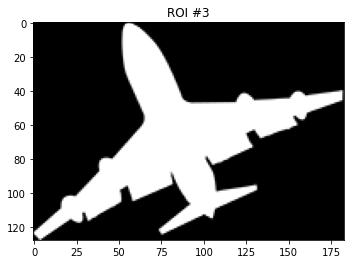

In [5]:
# find contours
cnts = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL,
                       cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

for (i,c) in enumerate(cnts):
    #extract ROI of from image and compute Hu Moments feature
    (x,y,w,h) = cv2.boundingRect(c)
    roi = image[y:y+h,x:x+w]
    moments = cv2.HuMoments(cv2.moments(roi)).flatten()
    
    print("Moments for plane #{}: {}".format(i+1, moments))
    display_image("ROI #{}".format(i+1), roi)

## Detecting outlier
- Generate 500 circle images and a rectangle image.


## Generating shapes

In [43]:
path = args["output"]
num_shapes = args["num_shapes"]

for i in range(num_shapes):
    canvas = np.zeros((500,500,3),dtype="uint8")
    #random radius
    radius = np.random.randint(20, 50, dtype="uint")
    
    #random center
    (x,y) = np.random.uniform(50, 450, size=(2,)).astype("int0")
        
    #random color
    color = np.random.randint(0, 255, size=(3,), dtype="int").astype("int0")
    color = tuple(map(int, color))
    img = cv2.circle(canvas, (x,y), radius, color, -1)
    cv2.imwrite("{}/{}.jpg".format(args["output"], uuid.uuid4()), img)

In [48]:
##write to disk a image with rectangle in it (the outlier)
image = np.zeros((500, 500, 3), dtype="uint8")
topleft = np.random.uniform(low=25, high=255, size=(2,)).astype("int0")
botright = np.random.uniform(low=250, high=400, size=(2,)).astype("int0")

color = np.random.uniform(low=0, high=255, size=(3,)).astype("int0")
color = tuple(map(int, color))
cv2.rectangle(image, tuple(topleft), tuple(botright), color, -1)
cv2.imwrite("{}/{}.jpg".format(args["output"], uuid.uuid4()), image)

True

## Finding Outlier
- Since Hu Moments are utilized to characterize the shape of an object in an image, we can assume that the distance between circles will be very small since they are visually similar to each other.
- We can assume the distance between the rectangle feature vector and all other circle feature vectors will be very large, since the rectangle is not as similar as all the other circles.
- we are obtaining scale invariance (i.e. the returned feature vector is not different for various sizes of an object) simply by resizing the ROI to a constant size.

Found square: ../images/output/b429548e-e48d-470a-90f5-de28a6eacdae.jpg


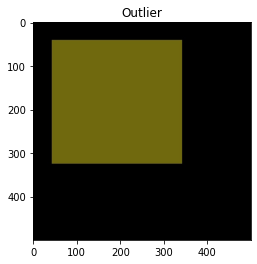

In [51]:
imagePaths = sorted(glob.glob(args["output"]+"/*.jpg"))
data = []

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (T,thresh) = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)
    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, 
                           cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    #extract ROI from image, resize it to conanical size,
    #compute hu moments feature vector and update matrix
    (x,y,w,h) = cv2.boundingRect(c)
    roi = cv2.resize(thresh[y:y+h, x:x+w], (50,50))
    moments = cv2.HuMoments(cv2.moments(roi)).flatten()
    data.append(moments)

#compute distance between all entries in the data matrix 
#then take sum of distance for each row, then followed by grabbing
#row with largest distance
D = pairwise_distances(data).sum(axis=1)
#row largest sum is taken because we know that row with rectangle 
#has high distance with each other shape
i = np.argmax(D)

image = cv2.imread(imagePaths[i])
print("Found square: {}".format(imagePaths[i]))
display_image("Outlier", image)